In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
from keras_preprocessing.image import ImageDataGenerator
from PIL import Image
import cv2

In [2]:
ROOT_DIR = "data"
os.listdir(ROOT_DIR)

['Moderately-differentiate',
 'Normal',
 'Poorly-differentiate',
 'Well-differentiate']

In [3]:
len(os.listdir(ROOT_DIR))

4

In [4]:
# count the number of images in each class
number_of_images = {}

for image_class in os.listdir(ROOT_DIR):
    number_of_images[image_class] = len(os.listdir(os.path.join(ROOT_DIR, image_class)))

number_of_images.items()

dict_items([('Moderately-differentiate', 180), ('Normal', 290), ('Poorly-differentiate', 261), ('Well-differentiate', 238)])

In [5]:
# Creating the train, validation and test folders
def dataFolder(p, split):
    if not os.path.exists("./" + p):
        os.mkdir("./" + p)

        for imageClass in os.listdir(ROOT_DIR):
            os.makedirs("./" + p + "/" + imageClass)
            for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, imageClass)),  #selecting images randomly
                                        size=(math.floor(split * number_of_images[imageClass]) - 5), replace=False):
                o = os.path.join(ROOT_DIR, imageClass, img)  #path
                d = os.path.join("./" + p, imageClass)
                shutil.copy(o, d)
                os.remove(o)
    else:
        print("the folder exist")

In [6]:
dataFolder("train", 0.7)

In [7]:
dataFolder("val", 0.15)

In [8]:
dataFolder("test", 0.15)

In [9]:
# count the number of images in each class
number_of_images = {}

for image_class in os.listdir('train'):
    number_of_images[image_class] = len(os.listdir(os.path.join('train', image_class)))

number_of_images.items()

dict_items([('Moderately-differentiate', 103), ('Normal', 169), ('Poorly-differentiate', 151), ('Well-differentiate', 137)])

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(rotation_range=45, width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='reflect')

In [15]:
def dataAugmentation(image_folder):
    dataset = []

    my_images = os.listdir(image_folder)
    for i, image_name in enumerate(my_images):
        image = cv2.imread(image_folder + image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((224, 224))
        dataset.append(np.array(image))

    x = np.array(dataset)

    i = 0
    for _ in datagen.flow(x, batch_size=32, save_to_dir=image_folder,
                          save_prefix='aug', save_format='jpg', shuffle=True):
        i += 1
        if i > 30:
            break

In [16]:
dataAugmentation('train/Normal/')

In [17]:
dataAugmentation('train/Well-differentiate/')

In [18]:
dataAugmentation('train/Poorly-differentiate/')

In [19]:
dataAugmentation('train/Moderately-differentiate/')

## Preparing the data

In [21]:
train_datagen = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rescale=1 / 255, horizontal_flip=True,)
train_images = train_datagen.flow_from_directory(directory='train', target_size=(224, 224),
                                                 batch_size=32, class_mode='categorical')

Found 4046 images belonging to 4 classes.


In [22]:
validation_datagen = ImageDataGenerator(rescale=1 / 255)
validation_images = validation_datagen.flow_from_directory(directory='val', target_size=(224, 224),
                                                           batch_size=32, class_mode='categorical')

Found 173 images belonging to 4 classes.


In [23]:
test_datagen = ImageDataGenerator(rescale=1 / 255)
test_images = test_datagen.flow_from_directory(directory='test', target_size=(224, 224),
                                               batch_size=32, class_mode='categorical')

Found 173 images belonging to 4 classes.


# Model Building

In [24]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LeakyReLU

In [25]:
# CNN model
learning_rate = 0.001
dropout_rate = 0.3
epochs = 30

optimizer = Adam(learning_rate=learning_rate)

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(rate=dropout_rate))

model.add(Flatten())

model.add(Dense(units=256, activation=LeakyReLU(alpha=0.1)))
model.add(BatchNormalization())
model.add(Dropout(rate=dropout_rate))

model.add(Dense(units=128, activation=LeakyReLU(alpha=0.1)))
model.add(BatchNormalization())
model.add(Dropout(rate=dropout_rate))

model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     2

In [26]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Adding Early stopping and Model Checkpoint

In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [40]:
# early stopping
es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=6, verbose=1, mode='auto')

# model checkpoint
mc = ModelCheckpoint(monitor="val_accuracy", filepath="./best_model_5.h5", save_best_only=True, verbose=1, mode='auto')

cd = [es, mc]

# Model Training

In [41]:
hs = model.fit(train_images,
               epochs=epochs,
               verbose=1,
               validation_data=validation_images,
               callbacks=cd)

Epoch 1/30
127/127 [==============================] - ETA: 0s - loss: 0.9228 - accuracy: 0.6122
Epoch 1: val_accuracy improved from -inf to 0.53179, saving model to .\best_model_5.h5
127/127 [==============================] - 305s 2s/step - loss: 0.9228 - accuracy: 0.6122 - val_loss: 1.2424 - val_accuracy: 0.5318
Epoch 2/30
127/127 [==============================] - ETA: 0s - loss: 0.9104 - accuracy: 0.6278
Epoch 2: val_accuracy improved from 0.53179 to 0.56069, saving model to .\best_model_5.h5
127/127 [==============================] - 304s 2s/step - loss: 0.9104 - accuracy: 0.6278 - val_loss: 1.0964 - val_accuracy: 0.5607
Epoch 3/30
127/127 [==============================] - ETA: 0s - loss: 0.8460 - accuracy: 0.6493
Epoch 3: val_accuracy did not improve from 0.56069
127/127 [==============================] - 300s 2s/step - loss: 0.8460 - accuracy: 0.6493 - val_loss: 2.5735 - val_accuracy: 0.4277
Epoch 4/30
127/127 [==============================] - ETA: 0s - loss: 0.8122 - accuracy:

In [42]:
h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<function matplotlib.pyplot.show(close=None, block=None)>

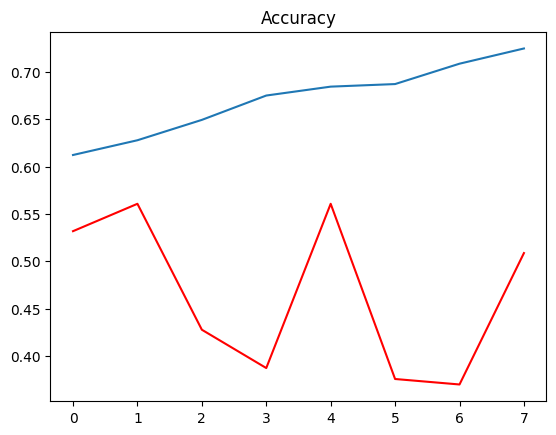

In [43]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c="red")
plt.title('Accuracy')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

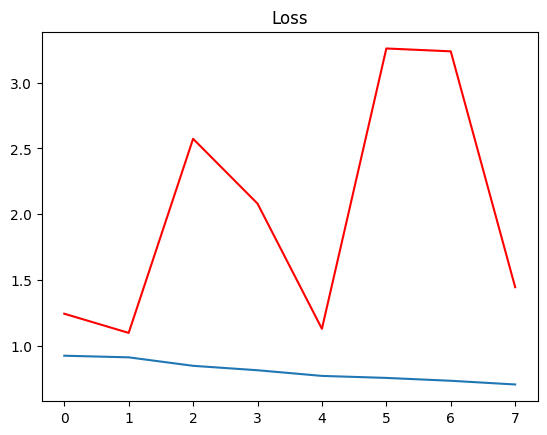

In [44]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c="red")
plt.title('Loss')
plt.show

# Model Accuracy

In [45]:
from keras.models import load_model

model = load_model('best_model_5.h5')

In [46]:
acc = model.evaluate(test_images)[1]
print(f"the accuracy of the model is {acc*100} %")

6/6 [==============================] - 8s 1s/step - loss: 1.2967 - accuracy: 0.5087
the accuracy of the model is 50.867050886154175 %
